In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm
from scipy.optimize import curve_fit

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *
from pulse_plot_maker import *

In [2]:
def plot_charge_injection(single_channel, is_averaged=False):
    low_range=single_channel[single_channel["CAPACITOR_TYPE"]==0]
    high_range=single_channel[single_channel["CAPACITOR_TYPE"]==1]

    high_non_zero=high_range[high_range['tot_max']>0]
    
    layer=single_channel["layer"].unique()[0]
    bar=single_channel["strip"].unique()[0]
    end=single_channel["end"].unique()[0]
    event=single_channel["EVENT"].unique()[0]
    
    avg_colors=["teal", "crimson"]
    colors=["darkslategrey", "maroon"]
    
    
    marker=["o", "x"]
    if is_averaged==False:
        plt.suptitle("Layer: "+str(layer)+" Bar: "+str(bar)+" End: "+str(end)+", Event: "+str(event))
    else:
        colors=avg_colors
        plt.suptitle("Layer: "+str(layer)+" Bar: "+str(bar)+" End: "+str(end))
        
    plt.subplot(1,2,1)
    plt.scatter((low_range["CALIB_DAC"]/2047)*0.5,low_range["tot_max"], label="TOT", color=colors[1])
    plt.scatter((low_range["CALIB_DAC"]/2047)*0.5,low_range["adc_max"], label="ADC", color=colors[0])
    plt.ylabel("ADC Ticks")
    plt.xlabel("Injection capacitance [pF]")
    plt.title("Low range")
    plt.legend()
    
    plt.subplot(1,2,2)
    
    plt.scatter((high_range["CALIB_DAC"]/2047)*8,high_range["tot_max"], label="TOT", color=colors[1])
    plt.scatter((high_range["CALIB_DAC"]/2047)*8,high_range["adc_max"], label="ADC", color=colors[0])
    plt.ylabel("ADC Ticks")
    plt.xlabel("Injection capacitance [pF]")
    #plt.xlim(-0.025,0.55)
    #plt.ylim(0,250)
    plt.title("High range")
    plt.legend()
    plt.show()

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
ci_folder="../../data/calibration/charge_injections/"
c_folder="../../data/calibration/"
Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/charge_injections").mkdir(parents=True, exist_ok=True)
p_folder="../../plots/charge_injections/"

In [5]:
charge_injection_runs=["scan_DPM0_CALIBRUN_coff14_20220419_073825.csv",
                       "scan_DPM0_CALIBRUN_coff14_20220424_071302.csv",
                       "scan_DPM0_CALIBRUN_coff14_20220424_220633.csv",
                       "scan_DPM1_CALIBRUN_coff14_20220419_081316.csv",
                       "scan_DPM1_CALIBRUN_coff14_20220424_071550.csv",
                       "scan_DPM1_CALIBRUN_coff14_20220424_220543.csv"]

In [6]:
linkmap=pd.read_csv(c_folder+"map.csv")
pedestal_df=pd.read_csv(c_folder+"pedestal.csv", sep=',') # normal pedestal_file needs to be used

In [7]:
# ALL prep
c0=pd.read_csv(ci_folder+charge_injection_runs[1])
merged0=c0.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged0.drop(["DPM", "ILINK", "CHAN", "SIPM_BIAS", "LINK"], axis=1, inplace=True)
merged0.drop(list(merged0.filter(regex = 'TOA.?')), axis=1, inplace=True)

pmerged=merged0.merge(pedestal_df, how="left", left_on=["PLANE", "STRIP", "END"], right_on=["layer", "strip", "end"])

for i in range(8):  # believe it or not, the loop is faster than a wildcard lookup
    adc_col = f'ADC{i}'
    pmerged[adc_col]-=pmerged["pedestal_per_time_sample"]

pmerged.drop(["PLANE", "STRIP", "END", "pedestal", "mean", "std_dev",
              "pedestal_per_time_sample", "pedestal_per_time_sample_mean", "pedestal_per_time_sample_std_dev"], axis=1, inplace=True)

In [8]:
ADC_max=pmerged[list(pmerged.filter(regex = 'ADC.?'))].max(axis=1)
pmerged=pmerged.assign(adc_max=ADC_max)
pmerged.drop(list(pmerged.filter(regex = 'ADC.?')), axis=1, inplace=True)

TOT_max=pmerged[list(pmerged.filter(regex = 'TOT.?'))].max(axis=1)
pmerged=pmerged.assign(tot_max=TOT_max)
pmerged.drop(list(pmerged.filter(regex = 'TOT.?')), axis=1, inplace=True)

In [12]:
def remove_adc_outlier(df):
    df["adc_diff"]=np.abs(df["adc_max"]-df["adc_max_mean"])
    max_adc_diff=df.groupby(["CAPACITOR_TYPE","CALIB_DAC"]).max()[["adc_diff"]]
    outliers=max_adc_diff[max_adc_diff["adc_diff"]>25]
    res_df=pd.merge(df,outliers, on=["CAPACITOR_TYPE", "CALIB_DAC", "adc_diff"],
                    indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    return res_df

def remove_tot_outlier(df):
    df["tot_diff"]=np.abs(df["tot_max"]-df["tot_max_mean"])
    max_adc_diff=df.groupby(["CAPACITOR_TYPE","CALIB_DAC"]).max()[["tot_diff"]]
    outliers=max_adc_diff[max_adc_diff["tot_diff"]>25]
    res_df=pd.merge(df,outliers, on=["CAPACITOR_TYPE", "CALIB_DAC", "tot_diff"],
                    indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    return res_df

In [21]:
def remove_outliers(df):
    df_avg=df.groupby(["CAPACITOR_TYPE","CALIB_DAC"]).mean().drop(["EVENT", "layer", "strip", "end"], axis=1)
    df_avg.rename(columns={"adc_max":"adc_max_mean", "tot_max":"tot_max_mean"}, inplace=True)

    df_merged=df.merge(df_avg, how="left", on=["CAPACITOR_TYPE", "CALIB_DAC"])
    res_df=remove_tot_outlier(remove_adc_outlier(df_merged)).drop(["adc_max_mean", "tot_max_mean", "adc_diff", "tot_diff"], axis=1)
    return res_df

In [86]:
def power_law(x,A, a,b,c):
    return a*((A-x)**b)+c

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])]


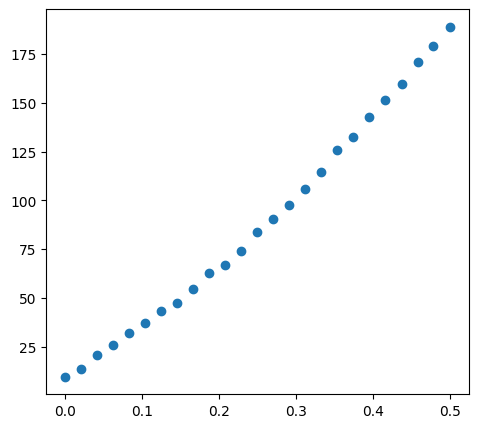

In [102]:
plt.rcParams["figure.figsize"]=(12,5)
for layer in np.sort(pmerged.layer.unique())[1:2]:
    for bar in np.sort(pmerged[pmerged["layer"]==layer].strip.unique())[:1]:
        for end in [0]:
            single_channel=pmerged[(pmerged["layer"]==layer) & (pmerged["strip"]==bar)&(pmerged["end"]==end)]

            clean_df=remove_outliers(single_channel).groupby(["CAPACITOR_TYPE","CALIB_DAC"]).mean().reset_index()
            low_adc=clean_df[clean_df["CAPACITOR_TYPE"]==0]
            diffs=[np.diff(clean_df[clean_df["CAPACITOR_TYPE"]==1]["adc_max"].values)>0]
            print(diffs)
            
            plt.subplot(1,2,1)
            plt.scatter(low_adc["CALIB_DAC"]/2047*0.5, low_adc["adc_max"])
            # plt.scatter(high_adc["CALIB_DAC"]/2047*8, high_adc["adc_max"])
            
            # low_tot=clean_df[(clean_df["tot_max"]>0) & (clean_df["CALIB_DAC"]<=300)]
            # high_tot=clean_df[(clean_df["CAPACITOR_TYPE"]==1) & (clean_df["CALIB_DAC"]>=300)]

            # high_param, _ = curve_fit(linear,(high_tot["CALIB_DAC"]), high_tot["tot_max"])
            # low_param, _ = curve_fit(power_law,(low_tot["CALIB_DAC"]), low_tot["tot_max"], p0=[1e4,])
            # print(low_param)
            # print(low_tot)
            # for event in [0,1,2]:
            #     plot_charge_injection(single_channel[single_channel["EVENT"]==event], False)
            # plt.subplot(1,2,1)
            # plt.scatter((low_tot["CALIB_DAC"]/2047)*8, low_tot["tot_max"])
            # plt.plot((low_tot["CALIB_DAC"]/2047)*8, power_law((low_tot["CALIB_DAC"]/2047)*8, *low_param))
            # plt.subplot(1,2,2)
            # plt.scatter((high_tot["CALIB_DAC"]/2047)*8, high_tot["tot_max"])
            # plt.plot((high_tot["CALIB_DAC"]/2047)*8, linear((high_tot["CALIB_DAC"]/2047)*8, *high_param))

In [83]:
high_param

array([211.40475261, 675.13589121])

In [88]:
low_param

array([nan, nan, nan, nan])

In [256]:
c0=pd.read_csv(ci_folder+charge_injection_runs[0])
c1=pd.read_csv(ci_folder+charge_injection_runs[1])
c2=pd.read_csv(ci_folder+charge_injection_runs[2])
c3=pd.read_csv(ci_folder+charge_injection_runs[3])
c4=pd.read_csv(ci_folder+charge_injection_runs[4])
c5=pd.read_csv(ci_folder+charge_injection_runs[5])

In [257]:
merged0=c0.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged1=c1.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged2=c2.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged3=c3.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged4=c4.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged5=c5.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])


merged0.drop(["DPM", "ILINK", "CHAN", "SIPM_BIAS", "LINK"], axis=1, inplace=True)

In [258]:
single_channel=merged0[(merged0["PLANE"]==1) & (merged0["STRIP"]==0) & (merged0["END"]==0)]

In [259]:
single_channel=merged5[(merged5["PLANE"]==16) & (merged5["STRIP"]==9) & (merged5["END"]==0)]

In [260]:
event=0

single_event=single_channel[single_channel["EVENT"]==event]

ADC_max=single_event[list(single_event.filter(regex = 'ADC.?'))].max(axis=1)
single_event=single_event.assign(ADC_MAX=ADC_max)

TOT_max=single_event[list(single_event.filter(regex = 'TOT.?'))].max(axis=1)
single_event=single_event.assign(TOT_MAX=TOT_max)

In [261]:
cap_1=single_event[single_event["CAPACITOR_TYPE"]==1]
cap_0=single_event[single_event["CAPACITOR_TYPE"]==0]

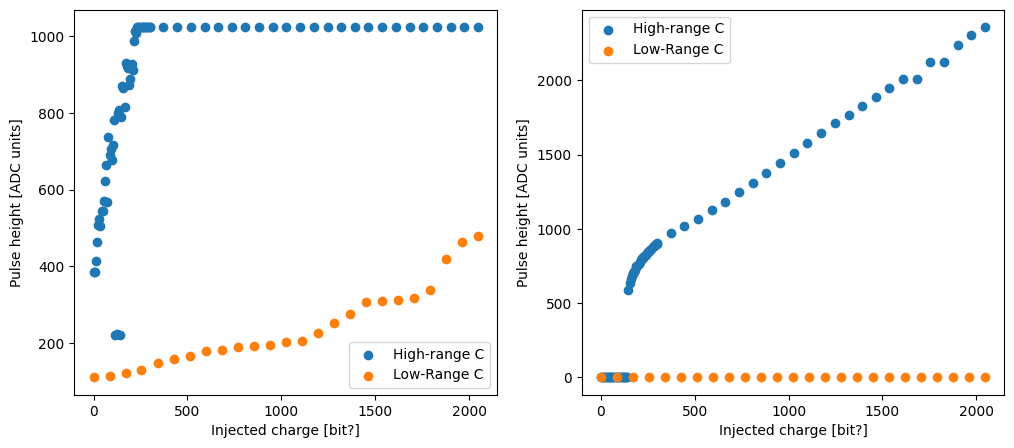

In [262]:
plt.rcParams["figure.figsize"]=(12,5)
plt.subplot(1,2,1)
plt.scatter(cap_1["CALIB_DAC"],cap_1["ADC_MAX"], label="High-range C")
plt.scatter(cap_0["CALIB_DAC"],cap_0["ADC_MAX"], label="Low-Range C")
plt.ylabel("Pulse height [ADC units]")
plt.xlabel("Injected charge [bit?]")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(cap_1["CALIB_DAC"],cap_1["TOT_MAX"], label="High-range C")
plt.scatter(cap_0["CALIB_DAC"],cap_0["TOT_MAX"], label="Low-Range C")
plt.ylabel("Pulse height [ADC units]")
plt.xlabel("Injected charge [bit?]")
plt.legend()
plt.show()

In [263]:
single_channel=merged3[(merged3["PLANE"]==16) & (merged3["STRIP"]==9) & (merged3["END"]==0)]

In [264]:
adcs=single_channel[list(single_channel.filter(regex = 'ADC.?'))]

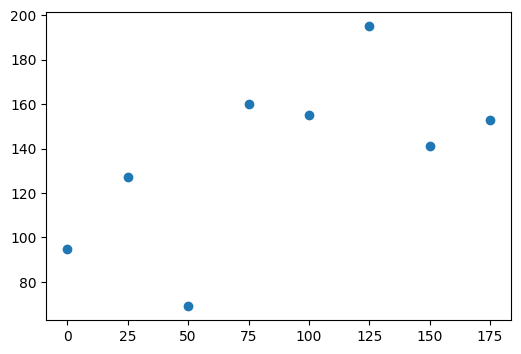

In [271]:

plt.rcParams["figure.figsize"]=(6,4)
plt.scatter(np.arange(0,200,25), adcs.loc[adcs.index[60]])